# SWMAL Exercise

(In the following you need not present your journal in the Qa+b+c+ etc. order. You could just present the final code with test and comments.)

## Training Your Own Linear Regressor

Create a linear regressor, with a Scikit-learn compatible fit-predict interface. You should implement every detail of the linear regressor in Python, using whatever libraries, say `numpy`, you want (except a linear regressor itself).

Below is a primitive _get-started_ skeleton for your implementation. Keep the class name `MyLinReg`, which is used in the test sequence later...

Running tests for MyLinReg
------------Testing on synthetic data------------
Training with method: BATCH
True coefficients: [87.73730719 74.07686178]
Learned coefficients: [48.19720214 47.48472489]
Learned intercept: -4.629192922410236
Test MSE: 1667.8697
Test R²: 0.8234


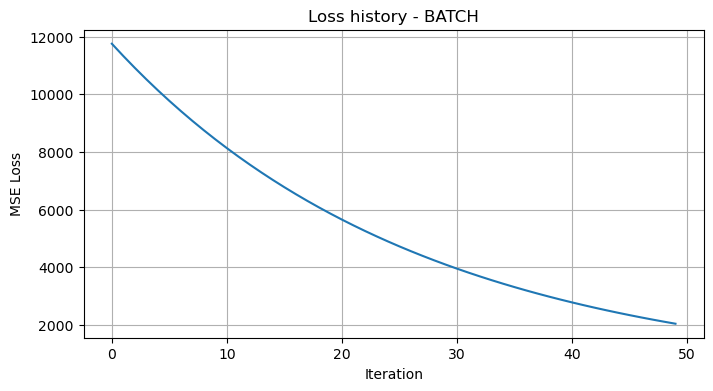

Training with method: SGD
True coefficients: [87.73730719 74.07686178]
Learned coefficients: [86.03462611 73.56178402]
Learned intercept: 0.30198659051522164
Test MSE: 154.0844
Test R²: 0.9837


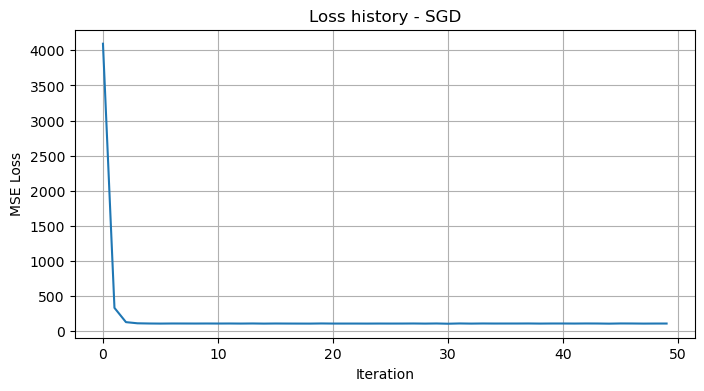

Training with method: MINI_BATCH
True coefficients: [87.73730719 74.07686178]
Learned coefficients: [78.27252849 70.4692452 ]
Learned intercept: -2.263439996435391
Test MSE: 205.5700
Test R²: 0.9782


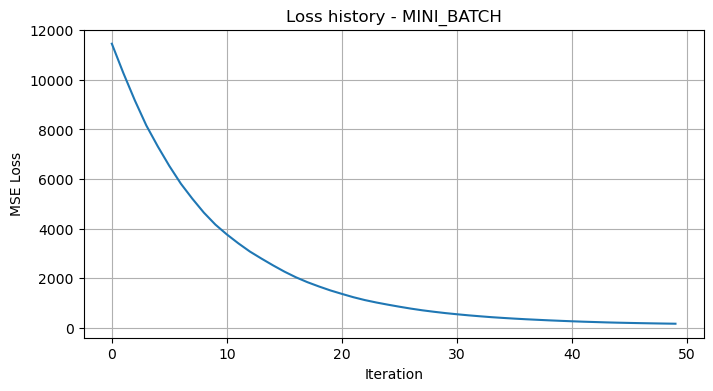

------------Testing on Iris data------------
Training with learning rate: 0.001
Test MSE: 15.0592
Test R²: -3.5949


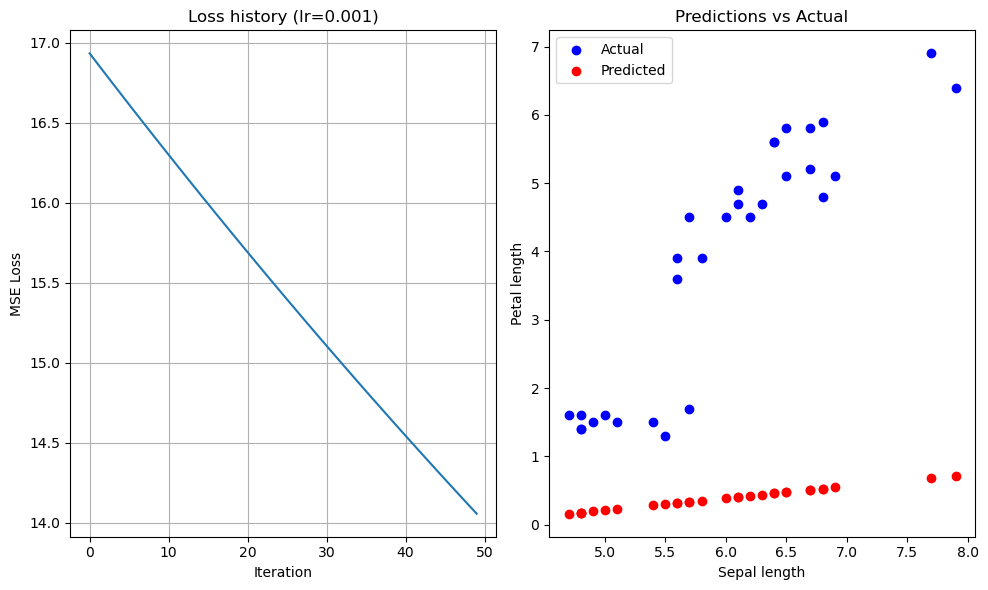

Training with learning rate: 0.01
Test MSE: 2.7475
Test R²: 0.1617


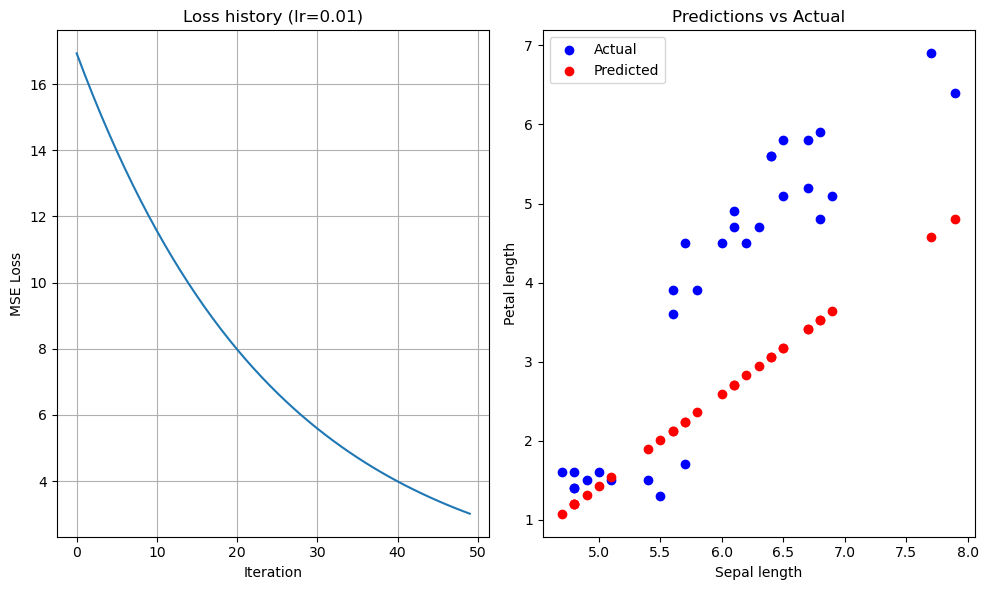

Training with learning rate: 0.1
Test MSE: 0.5961
Test R²: 0.8181


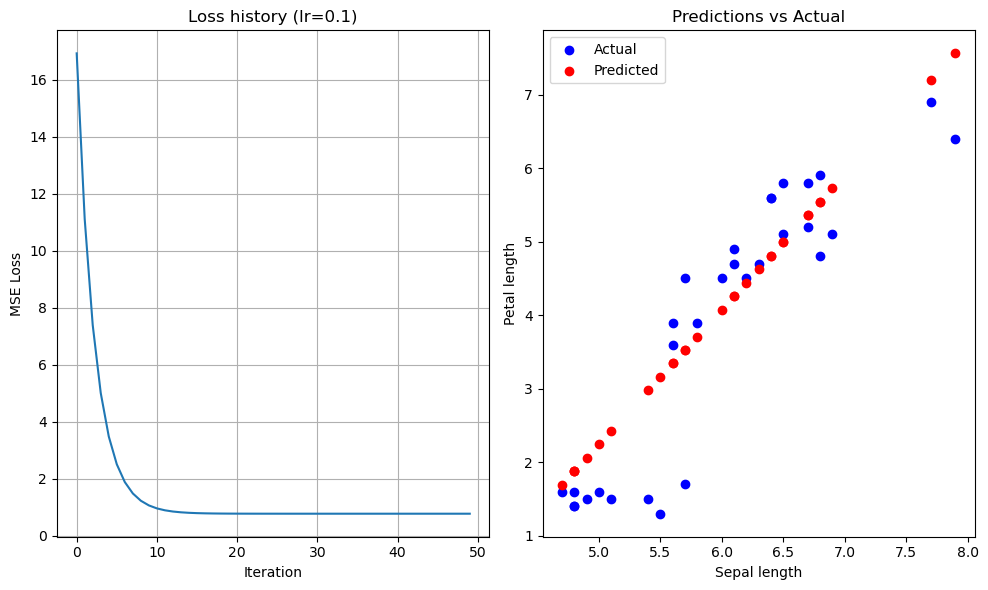

------------Testing adaptive learning rate------------


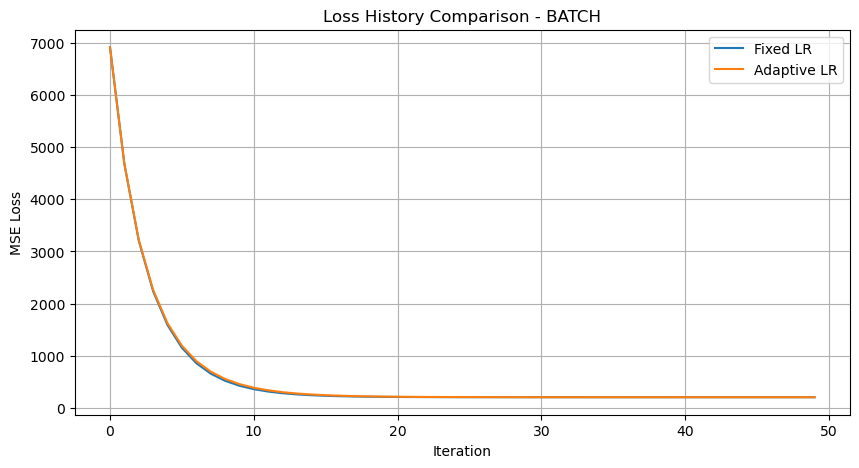


BATCH method:
Fixed LR - Test MSE: 278.5923, R²: 0.9592
Adaptive LR - Test MSE: 278.3252, R²: 0.9592


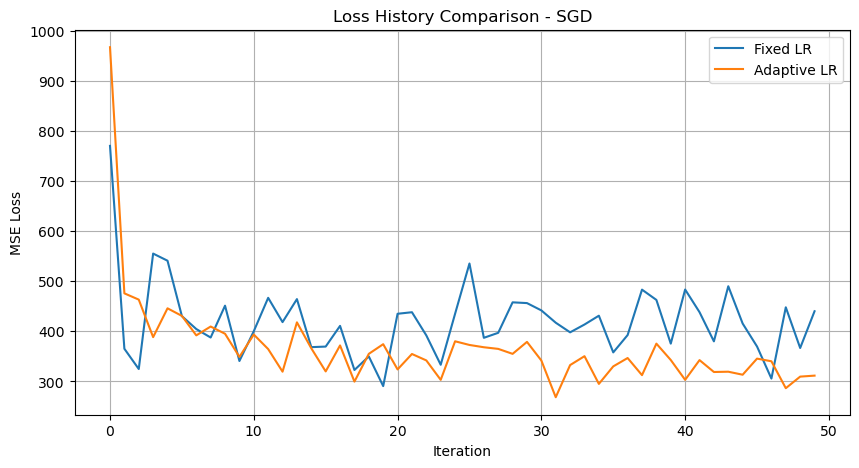


SGD method:
Fixed LR - Test MSE: 489.7633, R²: 0.9283
Adaptive LR - Test MSE: 391.6735, R²: 0.9426


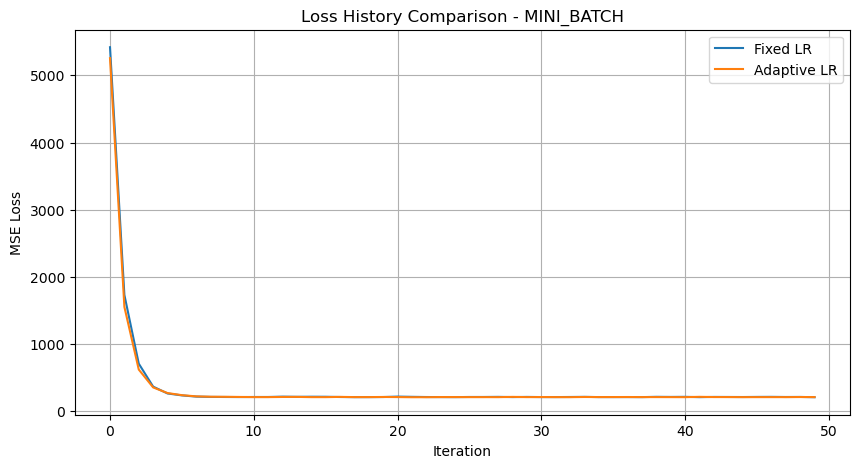


MINI_BATCH method:
Fixed LR - Test MSE: 280.7648, R²: 0.9589
Adaptive LR - Test MSE: 285.1389, R²: 0.9582
------------Comparing with sklearn------------
Performance comparison:
My Model - MSE: 278.5257, R²: 0.9592
sklearn LinearRegression - MSE: 278.6553, R²: 0.9592
sklearn SGDRegressor - MSE: 278.2662, R²: 0.9593

Coefficients comparison:
My Model - Coef: [28.58329409 74.04925847 19.27659122], Intercept: 1.9567601630627138
sklearn LinearRegression - Coef: [28.64039841 74.06228689 19.30000883], Intercept: 1.9556391790837484
sklearn SGDRegressor - Coef: [28.53510586 74.01942346 19.24000353], Intercept: [1.92852705]
All tests passed!


In [3]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.utils import shuffle

class MyLinReg:
    def __init__(self, eta0=0.01, max_iter=10, tol=1e-3, n_iter_no_change=5, verbose=True):
        self.eta0 = eta0
        self.max_iter = max_iter
        self.tol = tol
        self.n_iter_no_change = n_iter_no_change
        self.verbose = verbose

        self.coef_ = None
        self.intercept_ = None
        self.history_ = []
    
    def __str__(self):
        return "MyLinReg.__str__(): hi!"

    def _add_intercept(self, X):
        return np.c_[np.ones((X.shape[0], 1)), X]

    def _compute_loss(self, X, y, weights):
        y_pred = np.dot(X, weights)
        mse = np.mean((y-y_pred)**2)
        return mse
    
    def _compute_gradient(self, X, y, weights):
        m = X.shape[0]
        y_pred = np.dot(X, weights)
        gradient = (2/m) * X.T.dot(y_pred - y)
        return gradient
    
    def _get_adaptive_learning_rate(self, iteration, initial_lr=None):
        if initial_lr is None:
            initial_lr = self.eta0
        
        # Learning rate gradually decreases over iterations
        decay_rate = 0.01
        return initial_lr / (1 + decay_rate * iteration)
    
    def _batch_gradient_descent(self, X, y, adaptive_lr=False):
        n_samples, n_features = X.shape
        X_with_intercept = self._add_intercept(X)
        weights = np.zeros(n_features + 1)

        for i in range(self.max_iter):
            current_loss = self._compute_loss(X_with_intercept, y, weights)
            self.history_.append(current_loss)
            
            gradient = self._compute_gradient(X_with_intercept, y, weights)
            
            # Use adaptive or constant learning rate
            if adaptive_lr:
                lr = self._get_adaptive_learning_rate(i)
                weights -= lr * gradient
            else:
                weights -= self.eta0 * gradient

            if self.verbose and (i % 5 == 0 or i == self.max_iter - 1):
                if adaptive_lr:
                    curr_lr = self._get_adaptive_learning_rate(i)
                    print(f"Iteration {i+1}/{self.max_iter}: Loss = {current_loss:.6f}, Learning Rate = {curr_lr:.6f}")
                else:
                    print(f"Iteration {i+1}/{self.max_iter}: Loss = {current_loss:.6f}")
                
        self.intercept_ = weights[0]
        self.coef_ = weights[1:]

        return self
    
    def _stochastic_gradient_descent(self, X, y, adaptive_lr=False):
        n_samples, n_features = X.shape
        X_with_intercept = self._add_intercept(X)
        weights = np.zeros(n_features + 1)

        for i in range(self.max_iter):
            # Randomize the order of samples
            X_shuffled, y_shuffled = shuffle(X_with_intercept, y)

            epoch_loss = 0

            for j in range(n_samples):
                x_j = X_shuffled[j:j+1]
                y_j = y_shuffled[j:j+1]

                y_pred = np.dot(x_j, weights)
                error = y_j - y_pred

                gradient = (-2/1) * x_j.T.dot(error)
                
                if adaptive_lr:
                    # Adjust learning rate based on epoch and progress within epoch
                    lr = self._get_adaptive_learning_rate(i + j/n_samples)
                    weights -= lr * gradient
                else:
                    weights -= self.eta0 * gradient

                epoch_loss += (error**2)[0]

            epoch_loss /= n_samples
            self.history_.append(epoch_loss)
            
            if self.verbose and (i % 5 == 0 or i == self.max_iter - 1):
                if adaptive_lr:
                    curr_lr = self._get_adaptive_learning_rate(i)
                    print(f"Epoch {i+1}/{self.max_iter}: Loss = {epoch_loss:.6f}, Learning Rate = {curr_lr:.6f}")
                else:
                    print(f"Epoch {i+1}/{self.max_iter}: Loss = {epoch_loss:.6f}")
                
        self.intercept_ = weights[0]
        self.coef_ = weights[1:]

        return self
    
    def _mini_batch_gradient_descent(self, X, y, batch_size=32, adaptive_lr=False):
        n_samples, n_features = X.shape
        X_with_intercept = self._add_intercept(X)
        weights = np.zeros(n_features + 1)

        for i in range(self.max_iter):
            X_shuffled, y_shuffled = shuffle(X_with_intercept, y)

            epoch_loss = 0

            for j in range(0, n_samples, batch_size):
                end_idx = min(j + batch_size, n_samples)
                X_batch = X_shuffled[j:end_idx]
                y_batch = y_shuffled[j:end_idx]

                y_pred = np.dot(X_batch, weights)
                errors = y_batch - y_pred

                batch_size_actual = X_batch.shape[0]
                gradient = (-2/batch_size_actual) * X_batch.T.dot(errors)
                
                if adaptive_lr:
                    # Adjust learning rate based on epoch and batch progress
                    lr = self._get_adaptive_learning_rate(i + j/n_samples)
                    weights -= lr * gradient
                else:
                    weights -= self.eta0 * gradient

                epoch_loss += np.sum(errors**2)
            
            epoch_loss /= n_samples
            self.history_.append(epoch_loss)
            
            if self.verbose and (i % 5 == 0 or i == self.max_iter - 1):
                if adaptive_lr:
                    curr_lr = self._get_adaptive_learning_rate(i)
                    print(f"Epoch {i+1}/{self.max_iter}: Loss = {epoch_loss:.6f}, Learning Rate = {curr_lr:.6f}")
                else:
                    print(f"Epoch {i+1}/{self.max_iter}: Loss = {epoch_loss:.6f}")
            
        self.intercept_ = weights[0]
        self.coef_ = weights[1:]

        return self
    
    def fit(self, X, y, method='batch', batch_size=32, adaptive_lr=False):
        X = np.asarray(X)
        y = np.asarray(y)

        self.history_ = []

        if len(y.shape) > 1 and y.shape[1] > 1:
            raise ValueError("y must be a 1D array")
        
        if method == 'batch':
            return self._batch_gradient_descent(X, y, adaptive_lr)
        elif method == 'sgd':
            return self._stochastic_gradient_descent(X, y, adaptive_lr)
        elif method == 'mini_batch':
            return self._mini_batch_gradient_descent(X, y, batch_size, adaptive_lr)
        else:
            raise ValueError(f"Unknown method: {method}. Choose from 'batch', 'sgd', or 'mini_batch'")
        
    def predict(self, X):
        if self.coef_ is None or self.intercept_ is None:
            raise ValueError("Model not trained yet. Call fit() first.")
        
        X = np.asarray(X)
        return np.dot(X, self.coef_) + self.intercept_
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)
    
    def get_params(self, deep=True):
        return {
            'eta0': self.eta0,
            'max_iter': self.max_iter,
            'tol': self.tol,
            'n_iter_no_change': self.n_iter_no_change,
            'verbose': self.verbose
        }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression, load_iris
from sklearn.metrics import mean_squared_error

def test_on_synthetic_data():
    print("------------Testing on synthetic data------------")

    np.random.seed(42)
    X, y, coef = make_regression(n_samples=100, n_features=2, n_informative=2, noise=10, coef=True, random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    methods = ['batch', 'sgd', 'mini_batch']

    for method in methods:
        print(f"Training with method: {method.upper()}")
        model = MyLinReg(eta0=0.01, max_iter=50, verbose=False)
        model.fit(X_train, y_train, method=method)

        # Print true vs learned coefficients
        print(f"True coefficients: {coef}")
        print(f"Learned coefficients: {model.coef_}")
        print(f"Learned intercept: {model.intercept_}")

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Test MSE: {mse:.4f}")
        print(f"Test R²: {r2:.4f}")

        plt.figure(figsize=(8, 4))
        plt.plot(model.history_)
        plt.title(f'Loss history - {method.upper()}')
        plt.xlabel('Iteration')
        plt.ylabel('MSE Loss')
        plt.grid(True)
        plt.show()

def test_on_iris_data():
    print("------------Testing on Iris data------------")

    iris = load_iris()

    X = iris.data[:, 0].reshape(-1, 1) # Sepal length
    y = iris.data[:, 2] # Petal length

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    learning_rates = [0.001, 0.01, 0.1]

    for lr in learning_rates:
        print(f"Training with learning rate: {lr}")
        model = MyLinReg(eta0=lr, max_iter=50, verbose=False)
        model.fit(X_train_scaled, y_train)

        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        print(f"Test MSE: {mse:.4f}")
        print(f"Test R²: {r2:.4f}")

        plt.figure(figsize=(10, 6))

        plt.subplot(1, 2, 1)
        plt.plot(model.history_)
        plt.title(f'Loss history (lr={lr})')
        plt.xlabel('Iteration')
        plt.ylabel('MSE Loss')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.scatter(X_test, y_test, color='blue', label='Actual')
        plt.scatter(X_test, y_pred, color='red', label='Predicted')
        plt.xlabel('Sepal length')
        plt.ylabel('Petal length')
        plt.title('Predictions vs Actual')
        plt.legend()

        plt.tight_layout()
        plt.show()

def test_adaptive_learning_rate():
    print("------------Testing adaptive learning rate------------")
        
    # Create synthetic data
    np.random.seed(42)
    X, y = make_regression(n_samples=100, n_features=3, noise=15, random_state=42)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train with and without adaptive learning rate
    methods = ['batch', 'sgd', 'mini_batch']
    
    for method in methods:
        # Without adaptive learning rate
        model_fixed = MyLinReg(eta0=0.1, max_iter=50, verbose=False)
        model_fixed.fit(X_train_scaled, y_train, method=method, adaptive_lr=False)
        
        # With adaptive learning rate
        model_adaptive = MyLinReg(eta0=0.1, max_iter=50, verbose=False)
        model_adaptive.fit(X_train_scaled, y_train, method=method, adaptive_lr=True)
        
        # Compare loss histories
        plt.figure(figsize=(10, 5))
        plt.plot(model_fixed.history_, label='Fixed LR')
        plt.plot(model_adaptive.history_, label='Adaptive LR')
        plt.title(f'Loss History Comparison - {method.upper()}')
        plt.xlabel('Iteration')
        plt.ylabel('MSE Loss')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Compare MSE on test set
        y_pred_fixed = model_fixed.predict(X_test_scaled)
        y_pred_adaptive = model_adaptive.predict(X_test_scaled)
        
        mse_fixed = mean_squared_error(y_test, y_pred_fixed)
        mse_adaptive = mean_squared_error(y_test, y_pred_adaptive)
        
        r2_fixed = r2_score(y_test, y_pred_fixed)
        r2_adaptive = r2_score(y_test, y_pred_adaptive)
        
        print(f"\n{method.upper()} method:")
        print(f"Fixed LR - Test MSE: {mse_fixed:.4f}, R²: {r2_fixed:.4f}")
        print(f"Adaptive LR - Test MSE: {mse_adaptive:.4f}, R²: {r2_adaptive:.4f}")

def compare_with_sklearn():
    print("------------Comparing with sklearn------------")

    from sklearn.linear_model import LinearRegression, SGDRegressor

    # Create synthetic data
    np.random.seed(42)
    X, y = make_regression(n_samples=100, n_features=3, noise=15, random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    my_model = MyLinReg(eta0=0.1, max_iter=50, verbose=False)
    my_model.fit(X_train, y_train)

    sklearn_model = LinearRegression()
    sklearn_model.fit(X_train, y_train)

    sgd_model = SGDRegressor(loss='squared_error', max_iter=100, tol=1e-3, random_state=42)
    sgd_model.fit(X_train, y_train)

    my_pred = my_model.predict(X_test)
    sklearn_pred = sklearn_model.predict(X_test)
    sgd_pred = sgd_model.predict(X_test)

    my_mse = mean_squared_error(y_test, my_pred)
    sklearn_mse = mean_squared_error(y_test, sklearn_pred)
    sgd_mse = mean_squared_error(y_test, sgd_pred)

    my_r2 = r2_score(y_test, my_pred)
    sklearn_r2 = r2_score(y_test, sklearn_pred)
    sgd_r2 = r2_score(y_test, sgd_pred)

    print("Performance comparison:")
    print(f"My Model - MSE: {my_mse:.4f}, R²: {my_r2:.4f}")
    print(f"sklearn LinearRegression - MSE: {sklearn_mse:.4f}, R²: {sklearn_r2:.4f}")
    print(f"sklearn SGDRegressor - MSE: {sgd_mse:.4f}, R²: {sgd_r2:.4f}")
    
    print("\nCoefficients comparison:")
    print(f"My Model - Coef: {my_model.coef_}, Intercept: {my_model.intercept_}")
    print(f"sklearn LinearRegression - Coef: {sklearn_model.coef_}, Intercept: {sklearn_model.intercept_}")
    print(f"sklearn SGDRegressor - Coef: {sgd_model.coef_}, Intercept: {sgd_model.intercept_}")


if __name__ == "__main__":
    try:
        from sklearn.utils import shuffle
    except ImportError:
        print("Please install scikit-learn to run this example.")
        exit(1)
    print("Running tests for MyLinReg")

    test_on_synthetic_data()
    test_on_iris_data()
    test_adaptive_learning_rate()
    compare_with_sklearn()

    print("All tests passed!")



## The TODO list

You must investigate and describe all major details for a linear regressor, and implement at least the following concepts (MUST):

### Qa: Concepts and Implementations MUSTS

* Implement: the `fit-predict` interface, for a one-dimensional output only, 
* Implement: a $R^2$ score function (re-use existing code or perhaps just inherit it), 
* Implement: loss function based on (R)MSE,
* Implement: setting of the number of iterations and learning rate ($\eta$) via parameters in the constructor (the signature of your `__init__` must include the named parameters `eta0` and `max_iter`),
* (in a later exercise we will also add `tol`, `n_iter_no_change` and `verbose` to the constructor),
* Implement: the batch-gradient decent algorithm (GD),
* Implement: constant learning rate (maybe also adaptive learning rate if you are brave),
* Implement: stochastic gradient descent (SGD),
* Describe in text: epochs vs iterations,
* Describe in text: compare the numerical optimization with the Closed-form solution.

### Qb: [OPTIONAL] Additional Concepts and Implementations

And perhaps you could include (SHOULD/COULD):

* (stochastic) mini-bach gradient decent, 
* interface to your bias and weights via `intercept_` and `coef_` attributes on your linear regressor `class`,
* get/set functionality of your regressor, such that it is fully compatible with other Scikit-learn algorithms, try it out in say a `cross_val_score()` call from Scikit-learn,
* test in via the smoke tests at the end of this Notebook,
* testing it on MNIST data.

With the following no-no's (WONT):

* no learning graphs, no early stopping (we will do this in a later exercise),
* no multi-linear regression,
* no reuse of the Scikit-learn regressor,
* no `C/C++` optimized implementation with a _thin_ Python interface (nifty, but out-of-scope for this cause),
* no copy-paste of code from other sources WITHOUT a clear cite/reference for your source.

### Qc: Testing and Test Data

Use mainly very low-dimensional data for testing, say the IRIS set, since it might be very slow. Or create a simple low-dimensionality data generator.

(There is a _micro_ data set in the function `GenerateData` in the smoke tests functions below, but better is to opt for an realistic data set.)

### Qd: The Journaling of Your Regressor 

For the journal, write a full explanation of how you implemented the linear regressor, including a code walk-through (or mini-review of the most interesting parts).

### Qe: Mathematical Foundation for Training a Linear Regressor

You must also include the theoretical mathematical foundation for the linear regressor using the following equations and graphs (free to include in your journal without cite/reference), and relate them directly to your code:

* Design matrix of size $(n, d)$ where each row is an input column vector $(\mathbf{x}^{(i)})^\top$ data sample of size $d$

$$
    \def\rem#1{}
    \rem{ITMAL: CEF def and LaTeX commands v01, remember: no newlines in defs}
    \rem{MACRO eq: equation <#1:lhs> <#2:rhs>}
    \def\eq#1#2{#1 &=& #2\\}
    \rem{MACRO arr: array <#1:columns (lcr..)> <#2:content>}
    \def\ar#1#2{\begin{array}{#1}#2\end{array}}
    \rem{MACRO ac: array column vector <#1:columns (lcr..)> <#2:content>}
    \def\ac#1#2{\left[\ar{#1}{#2}\right]}
    \rem{MACRO st: subscript text <#1:content>}
    \def\st#1{_{\textrm{#1}}}
    \rem{MACRO norm: norm caligari L <#1:content>}
    \def\norm#1{{\cal L}_{#1}}
    \rem{MACRO obs: ??}
    \def\obs#1#2{#1_{\textrm{\scriptsize obs}}^{\left(#2\right)}}
    \rem{MACRO diff: math differetial operator <#1:content>}
    \def\diff#1{\mathrm{d}#1} 
    \rem{MACRO half: shorthand for 1/2}
    \def\half{\frac{1}{2}}
    \rem{MACRO pfrac: partial fraction <#1:numenator> <#2:denumenator>}
    \def\pfrac#1#2{\frac{\partial~#1}{\partial~#2}}
    \rem{MACRO dfrac: differetial operator fraction <#1:numenator> <#2:denumenator>}
    \def\dfrac#1#2{\frac{\mathrm{d}~#1}{\mathrm{d}#2}}
    \rem{MACRO pown: power and parantesis (train/test..) <#1:content>}
    \def\pown#1{^{(#1)}}
    \rem{MACROS powi, pown: shorthands for power (i) and (n)}
    \def\powni{\pown{i}}
    \def\pownn{\pown{n}}
    \rem{MACROS powtest, powertrain: power (test) and (train)}
    \def\powtest{\pown{\textrm{\scriptsize test}}}
    \def\powtrain{\pown{\textrm{\scriptsize train}}}
    \rem{MACRO boldmatrix: bold matix/vector notation} 
    \def\boldmatrix#1{\mathbf{#1}} 
    \rem{MACROS X,Z,x,y,w: bold X,Z,x etc.} 
    \def\bX{\boldmatrix{X}}
    \def\bZ{\boldmatrix{Z}}
    \def\bx{\boldmatrix{x}}
    \def\by{\boldmatrix{y}}
    \def\bw{\boldmatrix{w}}
    \def\bz{\boldmatrix{z}}
    \def\btheta{{\boldsymbol\theta}}
    \def\bSigma{{\boldsymbol\Sigma}}
    \rem{MACROS stpred, sttrue: shorthand for subscript 'pred' and 'true'}
    \def\stpred{\st{pred}~}
    \def\sttrue{\st{true}~}
    \rem{MACROS ypred, ytrue:   shorthand for scalar y 'pred' and 'true'}
    \def\ytrue{y\sttrue}
    \def\ypred{y\stpred} 
    \rem{MACROS bypred, bytrue: shorthand for vecor y 'pred' and 'true'} 
    \def\bypred{\boldmatrix{y}\stpred}
    \def\bytrue{\boldmatrix{y}\sttrue} 
\bX =
        \ac{cccc}{
            x_1\pown{1} & x_2\pown{1} & \cdots & x_d\pown{1} \\
            x_1\pown{2} & x_2\pown{2} & \cdots & x_d\pown{2} \\
            \vdots      &             &        & \vdots      \\
            x_1\pownn   & x_2\pownn   & \cdots & x_d\pownn   \\
        } 
$$

* Target ground-truth column vector of size $n$

$$
\bytrue =
  \ac{c}{
     y\pown{1}\sttrue \\
     y\pown{2}\sttrue \\
     \vdots           \\
     y\pown{n}\sttrue \\
  } 
$$

* Bias factor, and by convention in the following (prepend one)

$$
\ar{rl}{
  \ac{c}{1\\\bx\powni} & \mapsto \bx\powni\\
}
$$

* Weight column vector of size $d+1$ (i.e. with bias or intercept element $w_0$ prepended)

$$
\bw =
    \ac{c}{
         w_0    \\
         w_1    \\
         w_2    \\
         \vdots \\
         w_d    \\
    }
$$

* Linear regression model hypothesis function for a column vector input $\bx\powni$ of size $d$ and a column weight vector $\bw$ of size $d+1$
$$
\ar{rl}{
  ~~~~~~~~~~~~~~~
  h(\bx\powni;\bw) &= \ypred\powni \\
                   &= \bw^\top \bx\powni ~~~~ (\bx\powni~\textrm{with bias element})\\ 
                   &= w_0  \cdot 1+ w_1 x_1\powni + w_2 x_2\powni + \cdots + w_d x_d\powni & \\
}
$$

* Individual losses based on the $\norm{2}^2$ (last part assuming one dimensional output)

$$
\ar{rl}{
  L\powni &= || \ypred \powni         - \ytrue\powni~ ||_2^2\\
          &= || h(\bx\powni;\bw)      - \ytrue\powni~ ||_2^2\\
          &= || \bw^\top\bx\powni     - \ytrue\powni~ ||_2^2\\
          &= \left( \bw^\top\bx\powni - \ytrue\powni~ \right)^2 ~~~~~ \textrm{(only for 1D output)}
}
$$

* MSE loss function

$$
\ar{rl}{
    \textrm{MSE}(\bX,\bytrue;\bw)  &= \frac{1}{n} \sum_{i=1}^{n} L\powni \\
                                   &= \frac{1}{n} \sum_{i=1}^{n} \left( \bw^\top\bx\powni - y\powni\sttrue \right)^2\\
                                   &= \frac{1}{n} ||\bX \bw - \bytrue||_2^2
}
$$                   


* Loss function, proportional to (R)MSE

$$
\ar{rl}{
   J &= \frac{1}{2} ||\bX \bw - \bytrue||_2^2\\
     &  \propto \textrm{MSE}
}
$$

* Training: computing the optimal value of the $\bw$ weight; that is finding the $\bw$-value that minimizes the total loss

$$
  \bw^* = \textrm{argmin}_\bw~J\\
$$

* Visualization of $\textrm{argmin}_\bw$ means to the argument of $\bw$ that minimizes the $J$ function. The minimization can in 2-D visually be drawn as finding the lowest $J$ that for linear regression always forms a convex shape 

<img src="https://itundervisning.ase.au.dk/SWMAL/L05/Figs/minimization.png" alt="WARNING: could not get image from the server." style="height:240px">

#### Training I: The Closed-form Solution

* Finding the optimal weight in a _one-step_ analytic expression 

$$
  \bw^* ~=~ \left( \bX^\top \bX \right)^{-1}~ \bX^\top \bytrue
$$


#### Training II: Numerical Optimization 

* The Gradient of the loss function

$$   
  \nabla_\bw~J = \left[ \frac{\partial J}{\partial w_1} ~~~~ \frac{\partial J}{\partial w_2} ~~~~ \ldots  ~~~~ \frac{\partial J}{\partial w_d} \right]^\top
$$

* The Gradient for the based $J$

$$
\ar{rl}{
  \nabla_\bw J &= \frac{2}{n} \bX^\top \left( \bX \bw - \bytrue \right)
}
$$

* The Gradient Decent Algorithm (GD)

$$ 
  \bw^{(step~N+1)}~ = \bw^{(step~N)} ~ - \eta \nabla_{\bw} J
$$

* Visualization of GD, showing $J$ as a function of two $w$-dimensions

<img src="https://itundervisning.ase.au.dk/SWMAL/L05/Figs/minimization_gd.png" alt="WARNING: could not get image from the server." style="height:240px">

### Qf: Smoke testing

Once ready, you can test your regressor via the test stub below, or create your own _test suite_.

Be aware that setting the stepsize, $\eta$, value can be tricky, and you might want to tune `eta0` below.

In [2]:
# Mini smoke test for your linear regressor: TestMyLinReg

import sys
import numpy

### SOME NIFTY HELPER FUNS ###

def isVector(y, expected_n=-1):
    assert isinstance(y, numpy.ndarray), f"expected type 'numpy.array' but got {type(y)}"
    assert y.ndim==1, f"expected y.ndim==1 but got {y.ndim}"
    assert expected_n<0 or expected_n==y.shape[0], f"expected vector of size {expected_n} but got size {y.shape}"
    return True

def isMatrix(X, expected_m=-1, expected_n=-1):
    assert isinstance(X, numpy.ndarray), f"expected type 'numpy.array' but got {type(X)}"
    assert X.ndim==2, f"expected X.ndim==2 but got {X.ndim}"
    assert expected_m<0 or expected_m==y.shape[0], f"expected matrix of size {expected_m}x{expected_n} but got size {X.shape}"
    assert expected_n<0 or expected_n==y.shape[1], f"expected vector of size {expected_m}x{expected_n} but got size {X.shape}"
    return True

def PrintMatrix(x, label="", precision=12, linewidth=60):
    hasFancy = False
    try:
        # NOTE: how does multiple import behave, any performance issues?
        from libitmal.utils import PrintMatrix as FancyPrintMatrix
        hasFancy = True
    except Exception as ex:
        Warn("could not import PrintMatrix from libitmal.utils, defaulting to simple function..")

    if hasFancy:
        FancyPrintMatrix(x, label=label, precision=precision, linewidth=linewidth)
    else:
        # default simple implementation
        print(f"{label}{' ' if len(label)>0 else ''}{x}")

def Col(color):
    hasFancy = False
    try:
        from libitmal.Utils.colors import Col as FancyCol
        hasFancy = True
    except Exception as ex:
        Warn("could not import Col from libitmal.Utils.colors, defaulting to simple function..")

    if hasFancy:
        return FancyCol(color)
    else:
        return ""

def ColEnd():
    hasFancy = False
    try:
        from libitmal.Utils.colors import ColEnd as FancyColEnd
        hasFancy = True
    except Exception as ex:
        Warn("could not import Col from libitmal.Utils.colors, defaulting to simple function..")

    if hasFancy:
        return FancyColEnd()
    else:
        return ""

def PrintOutput(msg, pre_msg, ex=None, color="", filestream=sys.stdout):

    def FormatTxt(txt, linewidth=60, prefix="", replacetabs=True):
        assert isinstance(txt, str)
        assert isinstance(linewidth, int) and linewidth > 0
        assert isinstance(prefix, str)

        if replacetabs:
            txt = txt.replace("\t","    ")

        r = ""
        n = 0
        m = 0
        for i in txt:
            m += 1
            if n >= linewidth:
                if not i.isspace() and m < len(txt) and not txt[m].isspace():
                    r += "\\" # add hypen
                r += "\n" + prefix
                n = 0

            if n == 0 and i.isspace():
                continue # skip leading space

            r += i
            n += 1

            if i == "\n":
                r += prefix
                n = 0

        return r

    col_beg = Col(color)
    col_end = ColEnd()

    prefix = "".ljust(len(pre_msg)) 
    msg = FormatTxt(msg, prefix=prefix)
    
    print(f"{col_beg}{pre_msg}{msg}{col_end}\n", file=filestream)

    if ex is not None:
        #msg += f"\n   EXCEPTION: {ex} ({type(ex)})"
        PrintOutput(str(ex), prefix + "EXCEPTION: ", None, "red", filestream)


def Warn(msg, ex=None):
    PrintOutput(msg, "WARN:  ", ex, "lyellow")


def Err(msg, ex=None):
    PrintOutput(msg, "ERROR: ", ex, "lred" )
    raise Exception(msg) if ex is None else ex


def Info(msg):
    PrintOutput(msg, "INFO:  ", None, "lpurple")


def SimpleAssertInRange(x, expected, eps):
    #assert isinstance(x, numpy.ndarray)
    #assert isinstance(expected, numpy.ndarray)
    #assert x.ndim==1 and expected.ndim==1
    #assert x.shape==expected.shape
    assert eps>0
    assert numpy.allclose(x, expected, eps) # should rtol or atol be set to eps?


def GenerateData():
    X = numpy.array([[8.34044009e-01],[1.44064899e+00],[2.28749635e-04],[6.04665145e-01]])
    y = numpy.array([5.97396028, 7.24897834, 4.86609388, 3.51245674])
    return X, y


def TestMyLinReg():
    X, y = GenerateData()

    try:
        # assume that your regressor class is named 'MyLinReg', please update/change
        regressor = MyLinReg()
    except Exception as ex:
        Err("your regressor has another name, than 'MyLinReg', please change the name in this smoke test", ex)

    try:
        regressor = MyLinReg(max_iter=200)
    except Exception as ex:
        Err("your regressor can not be constructed via the __init_ for parameter 'max_iter'", ex)
    try:
        regressor = MyLinReg(eta0=0.01)
    except Exception as ex:
        Err("your regressor can not be constructed via the __init_ for parameter 'eta0'", ex)
    try:
        regressor = MyLinReg(verbose=False)
    except Exception as ex:
        Warn("your regressor can not be constructed via the __init_ for parameter 'verbose'", ex)
    try:
        regressor = MyLinReg(tol=1e-3)
    except Exception as ex:
        Warn("your regressor can not be constructed via the __init_ for parameter 'tol'", ex)
    try:
        regressor = MyLinReg(n_iter_no_change=1e-3)
    except Exception as ex:
        Warn("your regressor can not be constructed via the __init_ for parameter 'n_iter_no_change'", ex)

    # create regressor with default hyperparameter values
    # to be used for training, prediction and score..
    try:
        regressor = MyLinReg()
    except Exception as ex:
        Err("your regressor can not be constructed via the __init_ with default parameters", ex)


    try:
        regressor.fit(X, y)
    except Exception as ex:
        Err("your regressor can not fit", ex)

    try:
        y_pred = regressor.predict(X)
        Info(f"y_pred = {y_pred}")
    except Exception as ex:
        Err("your regressor can not predict", ex)


    try:
        score  = regressor.score(X, y)
        Info(f"SCORE = {Col('lblue')}{score}{ColEnd()}")
    except Exception as ex:
        Err("your regressor fails in the score call", ex)


    try:
        w    = None # default
        bias = None # default
        try:
            w = regressor.coef_
            bias = regressor.intercept_
        except Exception as ex:
            w = None
            Warn("your regressor has no coef_/intercept_ atrributes, trying Weights() instead..", ex)
        try:
            if w is None:
                w = regressor.Weights() # maybe a Weigths function is avalible on you model?
                try:
                    assert w.ndim == 1,     "can only handle vector like w's for now"
                    assert w.shape[0] >= 2, "expected length of to be at least 2, that is one bias one coefficient"
                    bias = w[0]
                    w = w[1:]
                except Exception as ex:
                    w = None
                    Err("having a hard time concantenating our bias and coefficients, giving up!", ex)
        except Exception as ex:
            w = None
            Err("your regressor also has no Weights() function, giving up!", ex)
        Info(f"bias         = {bias}")
        Info(f"coefficients = {w}")
    except Exception as ex:
        Err("your regressor fails during extraction of bias and weights (but is a COULD)", ex)

    try:
        from libitmal.utils import PrintMatrix
    except Exception as ex:
        PrintMatrix = SimplePrintMatrix # fall-back
        Warn("could not import PrintMatrix from libitmal.utils, defaulting to simple function..")

    try:
        from libitmal.utils import AssertInRange
    except Exception as ex:
        AssertInRange = SimpleAssertInRange # fall-back
        Warn("could not import AssertInRange from libitmal.utils, defaulting to simple function..")

    try:
        if w is not None:
            if bias is not None:
                w = numpy.concatenate(([bias], w)) # re-concat bias an coefficients, may be incorrect for your implementation!
            
            # TEST VECTOR:
            w_expected = numpy.array([4.046879011698, 1.880121487278])
            
            PrintMatrix(w,          label="       w         =")
            PrintMatrix(w_expected, label="       w_expected=")
            print()
            
            eps = 1E-2 # somewhat big epsilon, allowing some slack..
            AssertInRange(w, w_expected, eps)
            Info("Well, good news, your w and the expected w-vector seem to be very close numerically, so the smoke-test has passed!")
            
            return regressor
        else:
            Warn("cannot test due to missing w information")
    except Exception as ex:
        Err("mini-smoketest on your regressor failed", ex)
    
    return None

Warn("This mini smoke-test may produce false-positives and/or\n false-negatives..")
TestMyLinReg()

print("OK")

RecursionError: maximum recursion depth exceeded

### Qg: [OPTIONAL] More Smoke-Testing

Do you dare to compare your custom regressor with the SGD regressor in Scikit-learn on both the IRIS and MNIST datasets?

Then run the next smoke-test function, but the code might requre `eta0` anb `max_iter` hyperparamter tuning)..

In [ ]:
from sklearn.linear_model    import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.pipeline        import Pipeline

try:
    from libitmal import dataloaders
except Exception as ex:
    Err("can not import dataloaders form libitmal, and then I can not run the TestAndCompareRegressors smoke-test, sorry!", ex)

def TestAndCompareRegressors():
    for f in [("IRIS",  dataloaders.IRIS_GetDataSet,  1E-2),
              ("MNIST", dataloaders.MNIST_GetDataSet, 1E-3)]:
        
        # NOTE: f-tuble is (<name>, <data-loader-function-pointer>, <eps0>)
        data = f[1]() # returns (X, y)
        X_train, X_test, y_train, y_test = train_test_split(data[0], data[1])
        
        Info(f"DATA: '{f[0]}'\n\tSHAPES: X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}")

        eta0 = f[2] # an adaptive learning rate is really needed here!
        regressor0 = MyLinReg(eta0=eta0, max_iter=1000)
        regressor1 = SGDRegressor()    

        for r in [("MyLinReg", regressor0), ("SGDRegressor", regressor1)]:
            Info(f"\nTRAINING['{r[0]}']..")
            
            pipe = Pipeline([('scaler', StandardScaler()), r])
            pipe.fit(X_train, y_train)
            
            y_pred_test = pipe.predict(X_test)
            
            PrintMatrix(y_pred_test, label="y_pred_test=", precision=4)
            print()
            
            r2 = pipe.score(X_test, y_test)
            Info(f"SCORE['{r[0]}'] = {Col('lblue')}{r2:0.3f}{ColEnd()}")
            
        Info("\n##############################################\n")

# somewhat more verbose testing, you regressor will likely fail on MNIST 
# or at least be very, very slow...
TestAndCompareRegressors()

print("OK")

### Qh Conclusion

As always, take some time to fine-tune your regressor, perhaps just some code-refactoring, cleaning out 'bad' code, and summarize all your findings
 above. 

In other words, write a conclusion.

REVISIONS||
:- | :- |
2022-12-22| CEF, initial draft. 
2023-02-26| CEF, first release.
2023-02-28| CEF, fix a few issues related to import from libitmal, added Info and color output.
2024-09-19| CEF, major overhaul, change math/text and code snippets.
2024-09-25| CEF, final fixes, tests, and proof-reading. Moved early stopping and learning graphs to a later excercise.
2024-10-04| CEF, clarified Qa with respect to what-is-to-be implemented and what-is-to-be described in text only.